In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from math import pi
from pprint import pprint
from datetime import datetime
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.layouts import column
from bokeh.models import BooleanFilter, CDSView, Select, Range1d, HoverTool
from bokeh.palettes import Category10
from bokeh.models.formatters import NumeralTickFormatter
from config import *

In [2]:
dow = pd.read_csv('Resources/DowJones.csv')
nasdaq = pd.read_csv('Resources/Nasdaq.csv')
sp500 = pd.read_csv('Resources/SP500.csv')
merged_df = pd.merge(dow,nasdaq, how='left', on='Date', suffixes=(' Dow', ' Nasdaq'))
merged_df = pd.merge(merged_df, sp500, how='left', on='Date')
merged_df.rename(columns={'Value': 'Value S&P 500'}, inplace=True)
merged_df.head()

,Date,Value Dow,Value Nasdaq,Value S&P 500
0,1977-09-02,872.31,100.83,97.45
1,1977-09-09,857.04,100.91,96.37
2,1977-09-16,856.81,100.74,96.48
3,1977-09-23,839.14,99.57,95.04
4,1977-09-30,847.11,100.85,96.53


In [3]:
merged_df.to_csv('Resources/merged.csv', index=False)

In [4]:
merged_df['Date']= pd.to_datetime(merged_df['Date'])
merged_df.dtypes

Date             datetime64[ns]
Value Dow               float64
Value Nasdaq            float64
Value S&P 500           float64
dtype: object

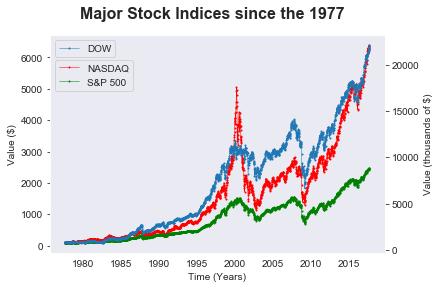

In [5]:
sns.set_style('dark')

x_axis = merged_df['Date']

fig, ax1 = plt.subplots()
fig.suptitle("Major Stock Indices since the 1977", fontsize=16, fontweight="bold")

ax1.plot(x_axis, merged_df['Value Nasdaq'], linewidth=0.5, marker="o", color="r", markersize=1, label='NASDAQ')

ax1.plot(x_axis, merged_df['Value S&P 500'], linewidth=0.5, marker="o", color="g", markersize=1, label='S&P 500')
ax1.set_ylabel("Value ($)")
ax1.set_xlabel("Time (Years)")
plt.legend(loc='upper left',bbox_to_anchor=(0,0.91))

ax2 = ax1.twinx()
ax2.plot(x_axis, merged_df['Value Dow'], linewidth=0.5, marker="o", markersize=1, label='DOW')
ax2.tick_params(axis='y')
ax2.set_ylabel("Value (thousands of $)")

plt.legend(loc='upper left', bbox_to_anchor=(0,1))
plt.savefig('Figures/StocksSince1977')
plt.show()

In [9]:
base_url = f'https://finnhub.io/api/v1'
opn = []
close = []
high = []
low = []
vol = []
time = []
dates = []

start_date = datetime(2019,1,1,12,0,0)
start_date = int(datetime.timestamp(start_date))

end_date = datetime(2020,7,24,12,0,0)
end_date = int(datetime.timestamp(end_date))

stk = 'AAPL'
query_url = f'{base_url}/stock/candle?symbol={stk}&resolution=D&from={start_date}&to={end_date}&token={Api_key}' 

response = requests.get(query_url).json()
opn = response['o']
close = response['c']
high = response['h']
low = response['l']
vol = response['v']
time = response['t']

for i in time:
    date = datetime.fromtimestamp(i).date()
    dates.append(date)
    
d = {"Date": dates,
    "Open": opn,
    "Close": close,
    "Low": low,
    "High": high,
    "Volume": vol}

candles_df = pd.DataFrame(d)
candles_df.head()

,Date,Open,Close,Low,High,Volume
0,2019-01-01,151.7650,154.7950,151.1050,155.7250,37039700
1,2019-01-02,141.1662,139.3763,139.1862,142.9062,91312200
2,2019-01-03,141.5961,145.3261,140.8661,145.6161,58607100
3,2019-01-06,145.7727,145.0027,142.9727,145.9027,54777800
4,2019-01-07,146.5769,147.7669,145.5369,148.8369,41025300


In [10]:
# Candlesticks for Apple (AAPL) stock since 2019

W_PLOT = 1250
H_PLOT = 600
TOOLS = 'pan,wheel_zoom,box_zoom,hover,reset,save'

VBAR_WIDTH = 12*60*60*1000
RED = Category10[4][3]
GREEN = Category10[4][2]

stock = ColumnDataSource(data=candles_df)
stock.data = stock.from_df(candles_df)

p = figure(x_axis_type="datetime",plot_width=W_PLOT, plot_height=H_PLOT, tools=TOOLS,
           title="Apple",toolbar_location='right')

inc = stock.data['Close'] > stock.data['Open']
dec = stock.data['Open'] > stock.data['Close']
view_inc = CDSView(source=stock, filters=[BooleanFilter(inc)])
view_dec = CDSView(source=stock, filters=[BooleanFilter(dec)])

 # map dataframe indices to date strings and use as label overrides
p.xaxis.major_label_overrides = {i+int(stock.data['index'][0]): date.strftime('%b %d') for i, date in enumerate(stock.data["Date"],1)}

p.segment(x0='Date', x1='Date', y0='Low', y1='High', color='black', source=stock, view=view_inc)
p.segment(x0='Date', x1='Date', y0='Low', y1='High', color='black', source=stock, view=view_dec)

p.vbar(x='Date', width=VBAR_WIDTH, top='Open', bottom='Close', fill_color=GREEN, line_color=GREEN,
       source=stock,view=view_inc, name="price")
p.vbar(x='Date', width=VBAR_WIDTH, top='Open', bottom='Close', fill_color=RED, line_color=RED,
       source=stock,view=view_dec, name="price")

p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')
p.xaxis.axis_label = 'Time'
p.x_range.range_padding = 0.05
p.xaxis.ticker.desired_num_ticks = 50    
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

# Select specific tool for the plot
price_hover = p.select(dict(type=HoverTool))

# Choose, which glyphs are active by glyph name
price_hover.names = ["price"]

# Creating tooltips
price_hover.tooltips = [("Datetime", "@Date{%Y-%m-%d}"),
                        ("Open", "@Open{$0,0.00}"),
                        ("Close", "@Close{$0,0.00}"),
                       ("Volume", "@Volume{($ 0.00 a)}")]
price_hover.formatters={"Date": 'datetime'}

show(p)

C:\Users\nabis\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\nabis\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\nabis\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

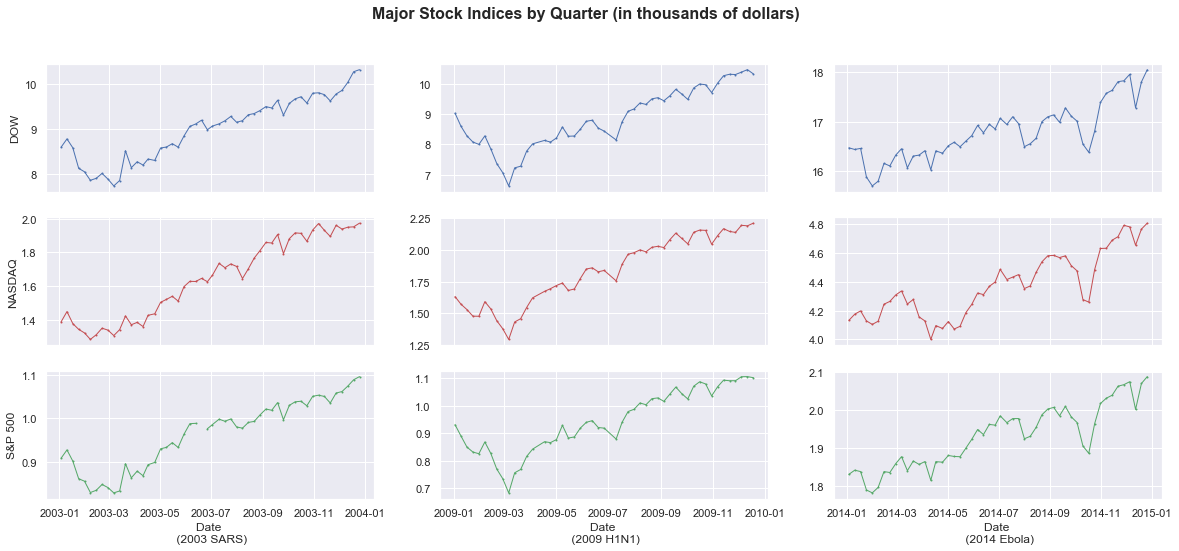

In [8]:
# SARS in 2003
# Swine Flu in 2009
# Ebola in 2014

sns.set(style='darkgrid')

# filtering for each of the years
yr_2003 = merged_df.loc[(merged_df['Date']>='2003-01-01')&(merged_df['Date']<='2003-12-31')]
yr_2003['Quarter'] = yr_2003['Date'].dt.quarter

yr_2009 = merged_df.loc[(merged_df['Date']>='2009-01-01')&(merged_df['Date']<='2009-12-31')]
yr_2009['Quarter'] = yr_2009['Date'].dt.quarter

yr_2014 = merged_df.loc[(merged_df['Date']>='2014-01-01')&(merged_df['Date']<='2014-12-31')]
yr_2014['Quarter'] = yr_2014['Date'].dt.quarter

# assigning x_values to each plot
x_axis_2003 = yr_2003['Date']
x_axis_2009 = yr_2009['Date']
x_axis_2014 = yr_2014['Date']

# creating a figure with 9 plots
fig, (ax1, ax2, ax3) = plt.subplots(3,3, sharex='col', figsize=(20,8))
fig.suptitle("Major Stock Indices by Quarter (in thousands of dollars)", fontsize=16, fontweight="bold")

# SARS April 2003
ax1[0].plot(x_axis_2003, yr_2003['Value Dow']/1000, linewidth=1, marker="o", markersize=1)
ax1[0].set_ylabel("DOW")

ax2[0].plot(x_axis_2003, yr_2003['Value Nasdaq']/1000, linewidth=1, marker="o", color="r", markersize=1)
ax2[0].set_ylabel("NASDAQ")

ax3[0].plot(x_axis_2003, yr_2003['Value S&P 500']/1000, linewidth=1, marker="o", color="g", markersize=1)
ax3[0].set_ylabel("S&P 500")
ax3[0].set_xlabel("Date \n (2003 SARS)")

# Swine Flu April 2009 (Pandemic)
ax1[1].plot(x_axis_2009, yr_2009['Value Dow']/1000, linewidth=1, marker="o", markersize=1)
# ax1[1].set_ylabel("2009 DOW")

ax2[1].plot(x_axis_2009, yr_2009['Value Nasdaq']/1000, linewidth=1, marker="o", color="r", markersize=1)
# ax2[1].set_ylabel("2009 NASDAQ")

ax3[1].plot(x_axis_2009, yr_2009['Value S&P 500']/1000, linewidth=1, marker="o", color="g", markersize=1)
# ax3[1].set_ylabel("2009 S&P 500")
ax3[1].set_xlabel("Date \n (2009 H1N1)")

# Ebola March 2014
ax1[2].plot(x_axis_2014, yr_2014['Value Dow']/1000, linewidth=1, marker="o", markersize=1)
# ax1[2].set_ylabel("2014 DOW")

ax2[2].plot(x_axis_2014, yr_2014['Value Nasdaq']/1000, linewidth=1, marker="o", color="r", markersize=1)
# ax2[2].set_ylabel("2014 NASDAQ")

ax3[2].plot(x_axis_2014, yr_2014['Value S&P 500']/1000, linewidth=1, marker="o", color="g", markersize=1)
# ax3[2].set_ylabel("2014 S&P 500")
ax3[2].set_xlabel("Date \n (2014 Ebola)")

plt.savefig('Figures/PandemicComparison')
plt.show()